In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torch.nn import CTCLoss
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

from dataset import SROIEOCRDataset, ocr_collate_fn, LabelConverter
from model import CRNN

# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Пути
DATA_ROOT = "../../data"
TRAIN_CSV = os.path.join(DATA_ROOT, "train.csv")
VAL_CSV = os.path.join(DATA_ROOT, "val.csv")
PRETRAINED_PATH = "pretrained/CRNN-PyTorchCTC.pth"

Используем устройство: cuda
CUDA доступна: True
GPU: NVIDIA GeForce MX450


In [ ]:
def decode_predictions(preds, input_lengths, label_converter):
    """
    Greedy decoding для CTC.
    preds: (T, B, num_classes)
    """
    preds = preds.permute(1, 0, 2)  # (B, T, C)
    _, max_index = torch.max(preds, dim=2)  # (B, T)

    texts = []
    for i, seq in enumerate(max_index):
        length = input_lengths[i]
        seq = seq[:length]
        decoded = []
        prev = 0
        for idx in seq:
            idx = idx.item()
            if idx != 0 and idx != prev:
                decoded.append(idx)
            prev = idx
        text = ''.join([label_converter.idx_to_char.get(i, '') for i in decoded])
        texts.append(text)
    return texts

def calculate_accuracy(pred_texts, gt_texts):
    correct_chars = 0
    total_chars = 0
    correct_words = 0
    total_words = len(gt_texts)

    for pred, gt in zip(pred_texts, gt_texts):
        total_chars += len(gt)
        correct_chars += sum(1 for a, b in zip(pred, gt) if a == b)
        if pred == gt:
            correct_words += 1

    char_acc = correct_chars / total_chars if total_chars > 0 else 0
    word_acc = correct_words / total_words if total_words > 0 else 0
    return char_acc, word_acc

In [41]:
def train_model(model, train_loader, val_loader, criterion,
    optimizer, scheduler, label_converter, device, num_epochs=5, save_path="best_model.pt"):
    """
    Обучает модель CRNN на заданное число эпох.
    
    Возвращает:
        train_losses, val_char_accs, val_word_accs
    """
    from tqdm import tqdm
    import torch

    best_val_word_acc = 0.0
    train_losses = []
    val_char_accs = []
    val_word_accs = []

    for epoch in range(num_epochs):
        # ===== Обучение =====
        model.train()
        epoch_loss = 0.0
        for images, targets, input_lengths, target_lengths in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"
        ):
            images = images.to(device)
            targets = targets.to(device)  # для CTCLoss targets должны быть на CPU, но PyTorch 2.0+ разрешает GPU
            input_lengths = input_lengths.to(device)
            target_lengths = target_lengths.to(device)

            optimizer.zero_grad()
            logits = model(images)  # (T, B, C)
            loss = criterion(logits, targets, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        scheduler.step()

        # ===== Валидация =====
        model.eval()
        all_pred_texts = []
        all_gt_texts = []

        with torch.no_grad():
            for images, targets, input_lengths, target_lengths in val_loader:
                images = images.to(device)
                # Получаем GT тексты
                start = 0
                gt_texts = []
                for t_len in target_lengths:
                    label_indices = targets[start:start + t_len].cpu().numpy()
                    text = ''.join([label_converter.idx_to_char.get(idx, '') for idx in label_indices])
                    gt_texts.append(text)
                    start += t_len

                logits = model(images)
                pred_texts = decode_predictions(logits, input_lengths.cpu(), label_converter)
                all_pred_texts.extend(pred_texts)
                all_gt_texts.extend(gt_texts)

        char_acc, word_acc = calculate_accuracy(all_pred_texts, all_gt_texts)
        val_char_accs.append(char_acc)
        val_word_accs.append(word_acc)

        print(f"Train Loss: {avg_train_loss:.4f} | Val Char Acc: {char_acc:.4f} | Val Word Acc: {word_acc:.4f}")

        # Сохраняем лучшую модель
        if word_acc > best_val_word_acc:
            best_val_word_acc = word_acc
            torch.save(model.state_dict(), save_path)
            print(f"Новая лучшая модель сохранена (Word Acc: {word_acc:.4f})")

    return train_losses, val_char_accs, val_word_accs

In [ ]:
# LabelConverter
label_converter = LabelConverter()
num_classes = label_converter.num_classes
print(f"Алфавит: {label_converter.alphabet}")
print(f"Число классов (включая blank): {num_classes}")

# Датасеты
train_dataset = SROIEOCRDataset(TRAIN_CSV, DATA_ROOT)
val_dataset = SROIEOCRDataset(VAL_CSV, DATA_ROOT)

# DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=ocr_collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=ocr_collate_fn, num_workers=0)

# Модель
model = CRNN(num_classes, hidden_size=128, num_lstm_layers=1, img_height=32).to(device)

Алфавит: 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ.,-/'()&$%:# +
Число классов (включая blank): 51


In [35]:
# Загрузка и адаптация предобученных весов
pretrained_dict = torch.load(PRETRAINED_PATH, map_location="cpu")

# Убираем 'module.' (если есть)
if list(pretrained_dict.keys())[0].startswith("module."):
    pretrained_dict = {k.replace("module.", ""): v for k, v in pretrained_dict.items()}

# Преобразуем 'FeatureExtraction.ConvNet.X' → 'cnn.X'
adapted_dict = {}
for k, v in pretrained_dict.items():
    if k.startswith("FeatureExtraction.ConvNet"):
        adapted_dict[k.replace("FeatureExtraction.ConvNet", "cnn")] = v
    # Если есть LSTM и он совпадает — можно добавить:

# Загружаем совместимые слои
model_dict = model.state_dict()
final_dict = {
    k: v for k, v in adapted_dict.items()
    if k in model_dict and v.shape == model_dict[k].shape
}
model.load_state_dict(final_dict, strict=False)
for param in model.cnn.parameters():
    param.requires_grad = False
print(f"✅ Загружено {len(final_dict)} слоёв")

✅ Загружено 22 слоёв


<ipython-input-35-3990bef0955f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(PRETRAINED_PATH, map_location="cpu")


In [36]:
criterion = CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
train_losses, val_char_accs, val_word_accs = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    label_converter=label_converter,
    device=device,
    num_epochs=35,
    save_path="best_model.pt"
)

Epoch 1/5: 100%|██████████| 901/901 [04:03<00:00,  3.69it/s]
Train Loss: 2.7412 | Val Char Acc: 0.1651 | Val Word Acc: 0.1434
Новая лучшая модель сохранена (Word Acc: 0.1434)
Epoch 2/5: 100%|██████████| 901/901 [04:06<00:00,  3.66it/s]
Train Loss: 0.8472 | Val Char Acc: 0.4393 | Val Word Acc: 0.3947
Новая лучшая модель сохранена (Word Acc: 0.3947)
Epoch 3/5: 100%|██████████| 901/901 [04:04<00:00,  3.69it/s]
Train Loss: 0.5321 | Val Char Acc: 0.5275 | Val Word Acc: 0.4863
Новая лучшая модель сохранена (Word Acc: 0.4863)
Epoch 4/5: 100%|██████████| 901/901 [04:05<00:00,  3.67it/s]
Train Loss: 0.4173 | Val Char Acc: 0.5886 | Val Word Acc: 0.5388
Новая лучшая модель сохранена (Word Acc: 0.5388)
Epoch 5/5: 100%|██████████| 901/901 [04:05<00:00,  3.67it/s]
Train Loss: 0.3534 | Val Char Acc: 0.6592 | Val Word Acc: 0.5881
Новая лучшая модель сохранена (Word Acc: 0.5881)
Epoch 1/5: 100%|██████████| 901/901 [04:04<00:00,  3.69it/s]
Train Loss: 0.3082 | Val Char Acc: 0.6814 | Val Word Acc: 0.6113
Новая лучшая модель сохранена (Word Acc: 0.6113)
Epoch 2/5: 100%|██████████| 901/901 [04:15<00:00,  3.52it/s]
Train Loss: 0.2734 | Val Char Acc: 0.7113 | Val Word Acc: 0.6352
Новая лучшая модель сохранена (Word Acc: 0.6352)
Epoch 3/5: 100%|██████████| 901/901 [04:43<00:00,  3.17it/s]
Train Loss: 0.2442 | Val Char Acc: 0.7349 | Val Word Acc: 0.6524
Новая лучшая модель сохранена (Word Acc: 0.6524)
Epoch 4/5: 100%|██████████| 901/901 [04:15<00:00,  3.52it/s]
Train Loss: 0.2241 | Val Char Acc: 0.7307 | Val Word Acc: 0.6603
Новая лучшая модель сохранена (Word Acc: 0.6603)
Epoch 5/5: 100%|██████████| 901/901 [04:10<00:00,  3.59it/s]
Train Loss: 0.2047 | Val Char Acc: 0.7727 | Val Word Acc: 0.6886
Новая лучшая модель сохранена (Word Acc: 0.6886)
Epoch 1/10: 100%|██████████| 901/901 [04:08<00:00,  3.63it/s]
Train Loss: 0.1793 | Val Char Acc: 0.7759 | Val Word Acc: 0.6947
Новая лучшая модель сохранена (Word Acc: 0.6947)
Epoch 2/10: 100%|██████████| 901/901 [04:10<00:00,  3.60it/s]
Train Loss: 0.1687 | Val Char Acc: 0.7923 | Val Word Acc: 0.7074
Новая лучшая модель сохранена (Word Acc: 0.7074)
Epoch 3/10: 100%|██████████| 901/901 [16:21<00:00,  1.09s/it]    
Train Loss: 0.1614 | Val Char Acc: 0.8057 | Val Word Acc: 0.7153
Новая лучшая модель сохранена (Word Acc: 0.7153)
Epoch 4/10: 100%|██████████| 901/901 [04:53<00:00,  3.07it/s]
Train Loss: 0.1533 | Val Char Acc: 0.7514 | Val Word Acc: 0.6810
Epoch 5/10: 100%|██████████| 901/901 [04:10<00:00,  3.59it/s]
Train Loss: 0.1453 | Val Char Acc: 0.8191 | Val Word Acc: 0.7303
Новая лучшая модель сохранена (Word Acc: 0.7303)
Epoch 6/10: 100%|██████████| 901/901 [04:10<00:00,  3.60it/s]
Train Loss: 0.1377 | Val Char Acc: 0.8093 | Val Word Acc: 0.7204
Epoch 7/10: 100%|██████████| 901/901 [04:09<00:00,  3.61it/s]
Train Loss: 0.1316 | Val Char Acc: 0.8071 | Val Word Acc: 0.7252
Epoch 8/10: 100%|██████████| 901/901 [04:11<00:00,  3.59it/s]
Train Loss: 0.1250 | Val Char Acc: 0.8255 | Val Word Acc: 0.7385
Новая лучшая модель сохранена (Word Acc: 0.7385)
Epoch 9/10: 100%|██████████| 901/901 [04:11<00:00,  3.58it/s]
Train Loss: 0.1191 | Val Char Acc: 0.8293 | Val Word Acc: 0.7462
Новая лучшая модель сохранена (Word Acc: 0.7462)
Epoch 10/10: 100%|██████████| 901/901 [04:10<00:00,  3.60it/s]
Train Loss: 0.1151 | Val Char Acc: 0.8276 | Val Word Acc: 0.7433
Epoch 1/5: 100%|██████████| 901/901 [04:07<00:00,  3.63it/s]
Train Loss: 0.1039 | Val Char Acc: 0.8341 | Val Word Acc: 0.7510
Новая лучшая модель сохранена (Word Acc: 0.7510)
Epoch 2/5: 100%|██████████| 901/901 [04:12<00:00,  3.57it/s]
Train Loss: 0.0998 | Val Char Acc: 0.8397 | Val Word Acc: 0.7525
Новая лучшая модель сохранена (Word Acc: 0.7525)
Epoch 3/5: 100%|██████████| 901/901 [04:09<00:00,  3.61it/s]
Train Loss: 0.0973 | Val Char Acc: 0.8401 | Val Word Acc: 0.7605
Новая лучшая модель сохранена (Word Acc: 0.7605)
Epoch 4/5: 100%|██████████| 901/901 [04:11<00:00,  3.58it/s]
Train Loss: 0.0942 | Val Char Acc: 0.8406 | Val Word Acc: 0.7599
Epoch 5/5: 100%|██████████| 901/901 [04:09<00:00,  3.61it/s]
Train Loss: 0.0921 | Val Char Acc: 0.8325 | Val Word Acc: 0.7519
Epoch 1/5: 100%|██████████| 901/901 [04:09<00:00,  3.62it/s]
Train Loss: 0.0893 | Val Char Acc: 0.8511 | Val Word Acc: 0.7643
Новая лучшая модель сохранена (Word Acc: 0.7643)
Epoch 2/5: 100%|██████████| 901/901 [04:11<00:00,  3.59it/s]
Train Loss: 0.0866 | Val Char Acc: 0.8474 | Val Word Acc: 0.7649
Новая лучшая модель сохранена (Word Acc: 0.7649)
Epoch 3/5: 100%|██████████| 901/901 [04:09<00:00,  3.61it/s]
Train Loss: 0.0842 | Val Char Acc: 0.8436 | Val Word Acc: 0.7595
Epoch 4/5: 100%|██████████| 901/901 [04:12<00:00,  3.57it/s]
Train Loss: 0.0819 | Val Char Acc: 0.8544 | Val Word Acc: 0.7694
Новая лучшая модель сохранена (Word Acc: 0.7694)
Epoch 5/5: 100%|██████████| 901/901 [04:15<00:00,  3.52it/s]
Train Loss: 0.0796 | Val Char Acc: 0.8550 | Val Word Acc: 0.7700
Новая лучшая модель сохранена (Word Acc: 0.7700)
Epoch 1/5: 100%|██████████| 901/901 [04:08<00:00,  3.63it/s]
Train Loss: 0.0520 | Val Char Acc: 0.8513 | Val Word Acc: 0.7681
Новая лучшая модель сохранена (Word Acc: 0.7681)
Epoch 2/5: 100%|██████████| 901/901 [04:08<00:00,  3.62it/s]
Train Loss: 0.0511 | Val Char Acc: 0.8513 | Val Word Acc: 0.7691
Новая лучшая модель сохранена (Word Acc: 0.7691)
Epoch 3/5: 100%|██████████| 901/901 [04:29<00:00,  3.34it/s]
Train Loss: 0.0502 | Val Char Acc: 0.8585 | Val Word Acc: 0.7735
Новая лучшая модель сохранена (Word Acc: 0.7735)
Epoch 4/5: 100%|██████████| 901/901 [04:43<00:00,  3.18it/s]
Train Loss: 0.0491 | Val Char Acc: 0.8507 | Val Word Acc: 0.7678
Epoch 5/5: 100%|██████████| 901/901 [04:10<00:00,  3.59it/s]
Train Loss: 0.0483 | Val Char Acc: 0.8504 | Val Word Acc: 0.7678

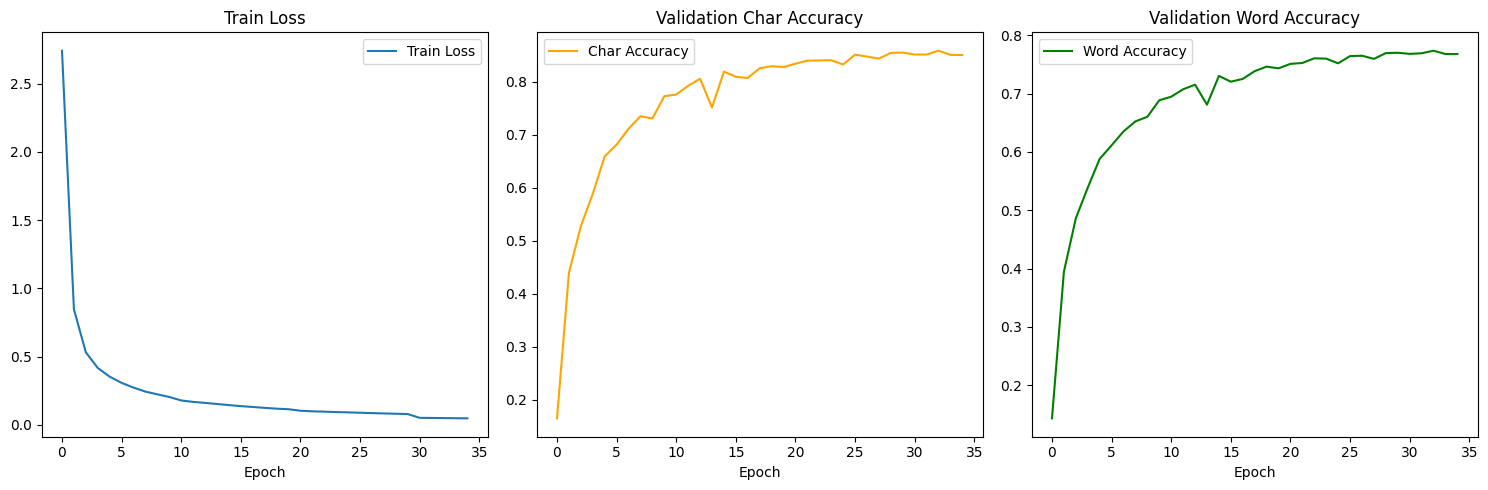

In [78]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_char_accs, label="Char Accuracy", color='orange')
plt.title("Validation Char Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_word_accs, label="Word Accuracy", color='green')
plt.title("Validation Word Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [61]:
TEST_CSV = os.path.join(DATA_ROOT, "test.csv")
test_dataset = SROIEOCRDataset(TEST_CSV, DATA_ROOT)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=ocr_collate_fn, num_workers=0)

In [ ]:
model.load_state_dict(torch.load("best_model.pt", map_location=device))

In [79]:
model.eval()
with torch.no_grad():
    for images, targets, input_lengths, target_lengths in test_loader:
        images = images.to(device)
        logits = model(images)
        pred_texts = decode_predictions(logits, input_lengths.cpu(), label_converter)
        
        # Получаем GT тексты
        start = 0
        gt_texts = []
        for t_len in target_lengths:
            label_indices = targets[start:start + t_len].cpu().numpy()
            text = ''.join([label_converter.idx_to_char.get(idx, '') for idx in label_indices])
            gt_texts.append(text)
            start += t_len
        
        for i in range(min(10, len(gt_texts))):
            print(f"GT: {gt_texts[i]} | Pred: {pred_texts[i]}")
        break

GT: TAN CHAY YEE | Pred: TAN CHAY YEE
GT:  COPY  | Pred:  COPY 
GT: OJC MARKETING SDN BHD | Pred: OJC MARKETING SDN BHD
GT: ROC NO: 538358-H | Pred: ROC NO: 538358-H
GT: TEL:07-388 2218 FAX:07-388 8218 | Pred: TEL:07388 2218FAX:07-388 8218
GT: EMAIL:NGOJCGROUP.COM | Pred: EMAIL: NGQOJCGROUP.COM
GT: TAX INVOICE | Pred: TAX INVOICE
GT: INVOICE NO | Pred: INVOICE NO
GT: : PEGIV-1030765 | Pred: :PEGIV 030765
GT: DATE | Pred: DATE
